In [1]:
import pandas as pd
import numpy as np
import kaggle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'KAGGLE_USERNAME'
os.environ['KAGGLE_KEY'] = 'KAGGLE_KEY'

In [4]:
#Retrieve the dataset

# Load the dataset
!kaggle datasets download -d jainilcoder/online-payment-fraud-detection -p ./data/

import zipfile

with zipfile.ZipFile('./data/online-payment-fraud-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/')

data = pd.read_csv('data\online-payment-fraud-detection.zip')

print('Data does not have any NULL value.')
data.isnull().any()

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())

# Display basic information about the dataset
print("\nBasic information about the dataset:")
print(data.info())

# Display summary statistics
print("\nSummary statistics of the dataset:")
print(data.describe())

# Check for missing values
print("\nChecking for missing values:")
print(data.isnull().sum())

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
C:\Users\luizf\AppData\Local\Temp\ipykernel_27380\1954495771.py:11: SyntaxWarning: invalid escape sequence '\o'
  data = pd.read_csv('data\online-payment-fraud-detection.zip')


Dataset URL: https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection
License(s): CC0-1.0
online-payment-fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Data does not have any NULL value.
First few rows of the dataset:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0     

In [11]:
# One-hot encode the 'type' column
data = pd.get_dummies(data, columns=['type'])

# Display the first few rows after encoding
print("First few rows after encoding:")
print(data.head())

First few rows after encoding:
   step    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  \
0     1   9839.64  C1231006815       170136.0       160296.36  M1979787155   
1     1   1864.28  C1666544295        21249.0        19384.72  M2044282225   
2     1    181.00  C1305486145          181.0            0.00   C553264065   
3     1    181.00   C840083671          181.0            0.00    C38997010   
4     1  11668.14  C2048537720        41554.0        29885.86  M1230701703   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  type_CASH_IN  \
0             0.0             0.0        0               0         False   
1             0.0             0.0        0               0         False   
2             0.0             0.0        1               0         False   
3         21182.0             0.0        1               0         False   
4             0.0             0.0        0               0         False   

   type_CASH_OUT  type_DEBIT  type_PAYMENT 

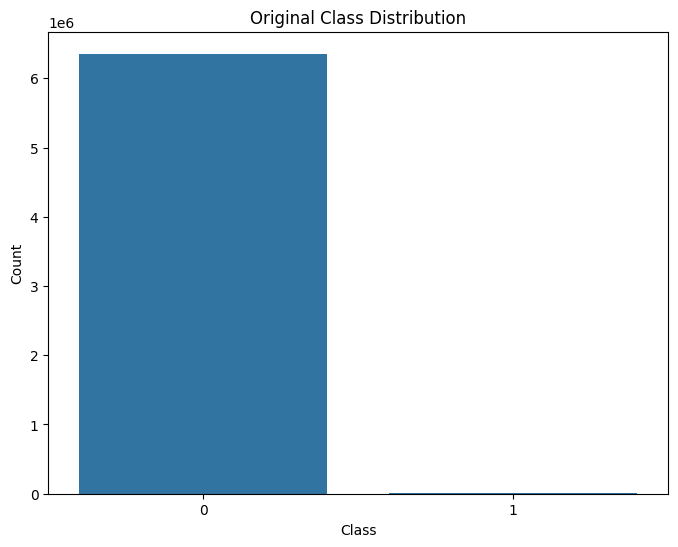

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'isFraud' is the name of the column with class labels
y = data['isFraud']  # Define 'y' with the appropriate column

# Plot original class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [13]:
import joblib
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame

# Define feature set and target variable
X = data.drop(columns=['nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud'])
y = data['isFraud']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the fitted scaler
joblib.dump(scaler, 'scalerlstm.pkl')

print("Data preprocessing with SMOTE completed.")


Data preprocessing with SMOTE completed.


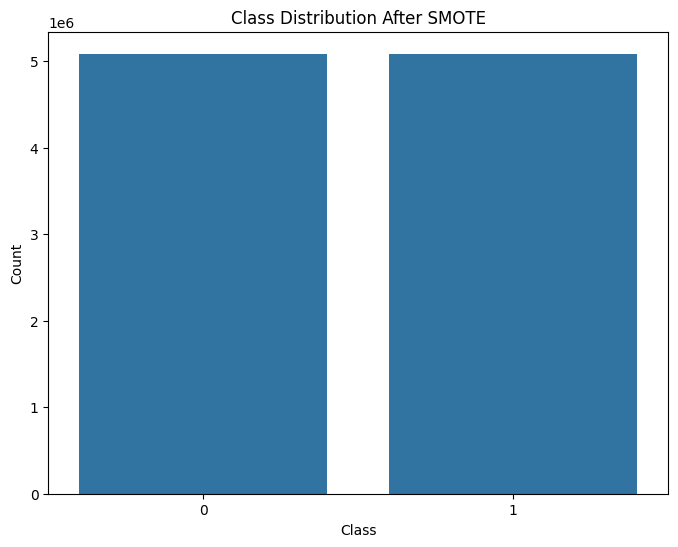

In [14]:

# Plot class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [16]:
model = Sequential()
model.add(LSTM(128, input_shape=(1, X_train.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))


c:\Users\luizf\AI_Final\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
142974/142974 ━━━━━━━━━━━━━━━━━━━━ 380s 3ms/step - accuracy: 0.9723 - loss: 0.0705 - val_accuracy: 0.9971 - val_loss: 0.0104
Epoch 2/5
142974/142974 ━━━━━━━━━━━━━━━━━━━━ 363s 3ms/step - accuracy: 0.9859 - loss: 0.0382 - val_accuracy: 0.9952 - val_loss: 0.0172
Epoch 3/5
142974/142974 ━━━━━━━━━━━━━━━━━━━━ 403s 3ms/step - accuracy: 0.9885 - loss: 0.0315 - val_accuracy: 0.9864 - val_loss: 0.0362
Epoch 4/5
142974/142974 ━━━━━━━━━━━━━━━━━━━━ 379s 3ms/step - accuracy: 0.9896 - loss: 0.0285 - val_accuracy: 0.9930 - val_loss: 0.0256
Epoch 5/5
142974/142974 ━━━━━━━━━━━━━━━━━━━━ 23005s 161ms/step - accuracy: 0.9904 - loss: 0.0266 - val_accuracy: 0.9971 - val_loss: 0.0150


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")


39767/39767 ━━━━━━━━━━━━━━━━━━━━ 51s 1ms/step


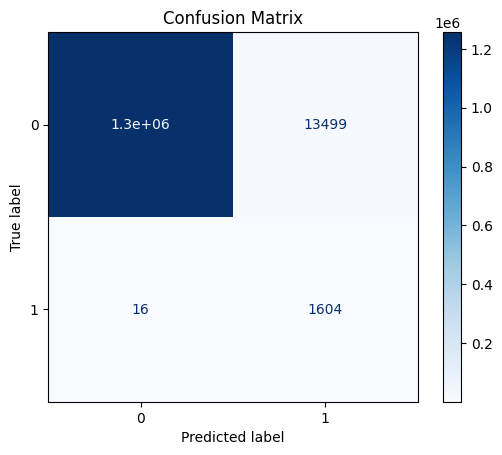

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [21]:
#model.save('final_model.h5')


In [22]:
#model.save('final_model.keras')